# Create aWhere Grid 

In [1]:
# Imports
import os
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np
import earthpy as et

In [3]:
# Set working directory
working_directory = os.path.join(
    et.io.HOME, 'earth-analytics', 
    '03-geog5663-earth-analytics-applications-summer-2020',
    'git-repos', 'fire-drought-analysis')

In [4]:
# Define path to shapefile
vt_bound_path = os.path.join(
    working_directory, '02-raw-data', 'shapefiles',
    'vermont_state_boundary.shp')

In [3]:
# Read shapefile into geodataframe
vt_bound_nad83 = gpd.read_file(vt_bound_path)

In [4]:
# Show projection
vt_bound_nad83.crs

{'proj': 'tmerc',
 'lat_0': 42.5,
 'lon_0': -72.5,
 'k': 0.999964286,
 'x_0': 500000,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

In [5]:
# Show bounds
vt_bound_nad83.bounds

,minx,miny,maxx,maxy
0,424788.84,25211.8369,581554.3701,279798.4736


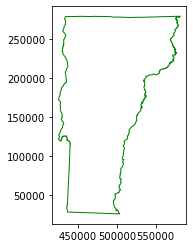

In [6]:
# Plot in NAD83 StatePlane VT
vt_bound_nad83.plot(facecolor='none', edgecolor='green')

In [7]:
# Project to WGS 84 Lat/Lon, EPSG 4326
vt_bound_4326 = vt_bound_nad83.to_crs(4326)

In [199]:
# Show projected CRS
vt_bound_4326.crs

4326

In [200]:
# Show bounds
vt_bound_4326.bounds

,minx,miny,maxx,maxy
0,-73.437902,42.72696,-71.465386,45.016665


In [201]:
# vt_bound_4326.geometry[0]

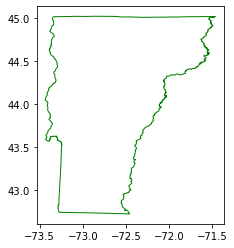

In [202]:
# Plot gdf
vt_bound_4326.plot(facecolor=('none'), edgecolor='green')

In [275]:
# Create buffer around state boundary - Where does 0.5 come from? Seems too high for VT
vt_bound_4326_buffer = vt_bound_4326.buffer(distance=0.05)

In [276]:
# Type
type(vt_bound_4326_buffer)

geopandas.geoseries.GeoSeries

In [277]:
# Info
vt_bound_4326_buffer

0    POLYGON ((-73.48712 44.05365, -73.48713 44.053...
dtype: geometry

In [278]:
# Convert buffer from geoseries to geodataframe
vt_bound_4326_buffer_gdf = gpd.GeoDataFrame(vt_bound_4326_buffer, crs=4326)

In [279]:
# Rename geometry column
vt_bound_4326_buffer_gdf.rename(columns={0: 'geometry'}, inplace=True)

In [280]:
# Display renamed gdf
vt_bound_4326_buffer_gdf

,geometry
0,"POLYGON ((-73.48712 44.05365, -73.48713 44.053..."


In [281]:
vt_bound_4326_buffer_gdf.crs

4326

In [282]:
# Get coords of boundary (buffered boundary)
lon_min = vt_bound_4326_buffer_gdf.bounds.minx[0]
lat_min = vt_bound_4326_buffer_gdf.bounds.miny[0]
lon_max = vt_bound_4326_buffer_gdf.bounds.maxx[0]
lat_max = vt_bound_4326_buffer_gdf.bounds.maxy[0]

In [283]:
print(f"Longitude - Min: {lon_min}, Max: {lon_max}")
print(f"Latitude - Min: {lat_min}, Max: {lat_max}")

Longitude - Min: -73.48789189929632, Max: -71.41541397988351
Latitude - Min: 42.676981803142034, Max: 45.06665946307827


In [284]:
# Define cell length/width
# Following documentation from aWhere, spaced at 0.08333 degrees or 5 arc-minutes
# Use 0.08 grid cell size so that one point should be in every grid cell 
# https://github.com/aWhereAPI/aWhere-R-Library/blob/master/R/create-awhere-grid.R
cell_size = 0.08

In [285]:
# Create lists for lat/lon extents
# Need to do any rounding here? Or is that already taken care
#  of with the buffering around the boundary?
lon_vals = np.arange(lon_min, lon_max, cell_size)
lat_vals = np.arange(lat_min, lat_max, cell_size)

In [286]:
# Create grid of polygons based on lat/lon ranges
grid_polys_list = [Polygon([
    (longitude, latitude),
    (longitude + cell_size, latitude),
    (longitude + cell_size, latitude + cell_size),
    (longitude, latitude + cell_size)])
    for longitude in lon_vals for latitude in lat_vals]

In [287]:
# Create geodataframe from grid polygons
grid_polys_gdf = gpd.GeoDataFrame(crs=4326, geometry=grid_polys_list)

In [288]:
# Add centroid to each grid cell
grid_polys_gdf['centroid'] = grid_polys_gdf.geometry.apply(
    lambda poly: poly.centroid)

In [289]:
# Show gdf, with centroids
grid_polys_gdf

,geometry,centroid
0,"POLYGON ((-73.48789 42.67698, -73.40789 42.676...",POINT (-73.44789 42.71698)
1,"POLYGON ((-73.48789 42.75698, -73.40789 42.756...",POINT (-73.44789 42.79698)
2,"POLYGON ((-73.48789 42.83698, -73.40789 42.836...",POINT (-73.44789 42.87698)
3,"POLYGON ((-73.48789 42.91698, -73.40789 42.916...",POINT (-73.44789 42.95698)
4,"POLYGON ((-73.48789 42.99698, -73.40789 42.996...",POINT (-73.44789 43.03698)
...,...,...
775,"POLYGON ((-71.48789 44.67698, -71.40789 44.676...",POINT (-71.44789 44.71698)
776,"POLYGON ((-71.48789 44.75698, -71.40789 44.756...",POINT (-71.44789 44.79698)
777,"POLYGON ((-71.48789 44.83698, -71.40789 44.836...",POINT (-71.44789 44.87698)
778,"POLYGON ((-71.48789 44.91698, -71.40789 44.916...",POINT (-71.44789 44.95698)


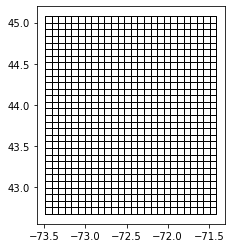

In [290]:
# Plot grid polys
grid_polys_gdf.plot(facecolor="none", edgecolor="black")

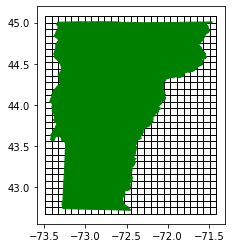

In [291]:
# Plot NON-buffered state boundary with grid cells
fig, ax = plt.subplots()

grid_polys_gdf.plot(ax=ax, facecolor="none", edgecolor="black")
vt_bound_4326.plot(ax=ax, facecolor='green', edgecolor="green")

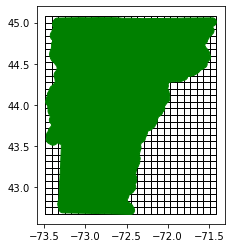

In [292]:
# Plot buffered state boundary with grid cells;
#  buffer of 0.5 seems extreme for a small US state;
#  what is a more appropriate buffer, 0.05?
fig, ax = plt.subplots()

grid_polys_gdf.plot(ax=ax, facecolor="none", edgecolor="black")
vt_bound_4326_buffer_gdf.plot(ax=ax, facecolor='green', edgecolor="green")

In [293]:
# Narrow grid cells to those within the buffered state boundary
if grid_polys_gdf.crs == vt_bound_4326_buffer_gdf.crs:
    vt_grid_4326 = gpd.sjoin(
        grid_polys_gdf, vt_bound_4326_buffer_gdf,
        op='within').drop(columns='index_right')
    
# Reset index
vt_grid_4326.reset_index(inplace=True, drop=True)

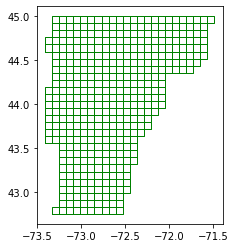

In [294]:
vt_grid_4326.plot(facecolor="none", edgecolor="green")

In [295]:
# Non-buffered
# gpd.sjoin(grid_polys_gdf, vt_bound_4326, op='within').plot(
#     facecolor="none", edgecolor="green")

In [296]:
# Extract list of cell centroids from point data that
#  can feed into batch production for aWhere data

In [297]:
vt_grid_4326.loc[[0]].centroid

0    POINT (-73.36789 43.59698)
dtype: geometry

In [298]:
# Copy grid for testing
vt_copy = vt_grid_4326.copy()

In [299]:
# Extract latitude and longitude to new columns
vt_copy['longitude'] = vt_copy.centroid.apply(lambda point: point.x)
vt_copy['latitude'] = vt_copy.centroid.apply(lambda point: point.y)

In [300]:
# Show df
vt_copy

,geometry,centroid,longitude,latitude
0,"POLYGON ((-73.40789 43.55698, -73.32789 43.556...",POINT (-73.36789 43.59698),-73.367892,43.596982
1,"POLYGON ((-73.40789 43.63698, -73.32789 43.636...",POINT (-73.36789 43.67698),-73.367892,43.676982
2,"POLYGON ((-73.40789 43.71698, -73.32789 43.716...",POINT (-73.36789 43.75698),-73.367892,43.756982
3,"POLYGON ((-73.40789 43.79698, -73.32789 43.796...",POINT (-73.36789 43.83698),-73.367892,43.836982
4,"POLYGON ((-73.40789 43.87698, -73.32789 43.876...",POINT (-73.36789 43.91698),-73.367892,43.916982
...,...,...,...,...
428,"POLYGON ((-71.64789 44.67698, -71.56789 44.676...",POINT (-71.60789 44.71698),-71.607892,44.716982
429,"POLYGON ((-71.64789 44.75698, -71.56789 44.756...",POINT (-71.60789 44.79698),-71.607892,44.796982
430,"POLYGON ((-71.64789 44.83698, -71.56789 44.836...",POINT (-71.60789 44.87698),-71.607892,44.876982
431,"POLYGON ((-71.64789 44.91698, -71.56789 44.916...",POINT (-71.60789 44.95698),-71.607892,44.956982


In [301]:
# Extract centroid (as tuples) from grid (for use to pull aWhere data from,
#  based on lat/lon coords)
centroid_list = [(row.longitude, row.latitude) for row in vt_copy.itertuples()]

In [302]:
# Show first 5 elements
centroid_list[:5]

[(-73.36789189929631, 43.596981803142015),
 (-73.36789189929631, 43.67698180314201),
 (-73.36789189929631, 43.75698180314201),
 (-73.36789189929631, 43.83698180314201),
 (-73.36789189929631, 43.916981803142015)]

In [303]:
# Show first element
centroid_list[:5][0]

(-73.36789189929631, 43.596981803142015)

In [304]:
# Show first longitude
centroid_list[:5][0][0]

-73.36789189929631

In [305]:
# Show first latitude
centroid_list[:5][0][-1]

43.596981803142015

In [17]:
def create_awhere_grid(study_area_path, buffer_distance, cell_size=0.08):
    """Creates an aWhere-sized grid (0.08 x 0.08 degree,
    5 arc-minute x 5 arc-minute grid) fit to a polygon.

    Parameters
    ----------
    study_area_path : str
        Path the polygon shapefile boundary.

    buffer_distance : int or float
        Buffer size in degrees (WGS 84 CRS).

    cell_size: int or float
        Grid size (x and y dimension) in degrees (WGS 84 CRS).

    Returns
    -------

    Example
    -------
    """
    # Read shapefile into geodataframe
    study_area = gpd.read_file(study_area_path)

    # Project to WGS 84 Lat/Lon, EPSG 4326 if no CRS match
    if not study_area.crs == 4326:
        study_area_4326 = study_area.to_crs(4326)

    else:
        study_area_4326 = study_area

    # Create buffer around state boundary
    study_area_4326_buffer = study_area_4326.buffer(distance=buffer_distance)

    # Convert buffer from geoseries to geodataframe
    study_area_4326_buffer_gdf = gpd.GeoDataFrame(
        study_area_4326_buffer, crs=4326)

    # Rename geometry column in buffer
    study_area_4326_buffer_gdf.rename(columns={0: 'geometry'}, inplace=True)

    # Get extent of buffered boundary
    longitude_min = study_area_4326_buffer_gdf.bounds.minx[0]
    latitude_min = study_area_4326_buffer_gdf.bounds.miny[0]
    longitude_max = study_area_4326_buffer_gdf.bounds.maxx[0]
    latitude_max = study_area_4326_buffer_gdf.bounds.maxy[0]

    # Create lists for lat/lon extents
    # DOES THIS NEED ANY PADDING? np.floor, np.ceil?
    # OR DOES DUFFER DISTANCE HANDLE THIS?
    longitude_vals = np.arange(longitude_min, longitude_max, cell_size)
    latitude_vals = np.arange(latitude_min, latitude_max, cell_size)

    # Create grid of polygons based on longitude and latitude ranges
    grid_polys_list = [Polygon([
        (longitude, latitude),
        (longitude + cell_size, latitude),
        (longitude + cell_size, latitude + cell_size),
        (longitude, latitude + cell_size)])
        for longitude in longitude_vals for latitude in latitude_vals]

    # Create geodataframe from grid polygons
    grid_polys_gdf = gpd.GeoDataFrame(crs=4326, geometry=grid_polys_list)

    # Add centroid to each grid cell
    grid_polys_gdf['centroid'] = grid_polys_gdf.geometry.apply(
        lambda poly: poly.centroid)

    # Narrow grid cells to those within the buffered boundary
    study_area_grid_4326 = gpd.sjoin(
        grid_polys_gdf, study_area_4326_buffer_gdf, op='within')
    
    # Return gridded geodataframe
    return study_area_grid_4326.drop(columns='index_right')

In [18]:
test_grid = create_awhere_grid(
    vt_bound_path, buffer_distance=0.5, cell_size=0.08)

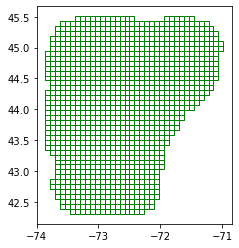

In [19]:
test_grid.plot(facecolor="none", edgecolor="green")

In [20]:
test_grid = create_awhere_grid(
    vt_bound_path, buffer_distance=0.1, cell_size=0.08)

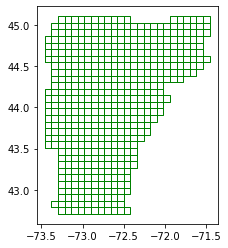

In [21]:
test_grid.plot(facecolor="none", edgecolor="green")

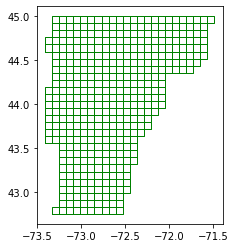

In [33]:
test_grid = create_awhere_grid(
    vt_bound_path, buffer_distance=0.05, cell_size=0.08)

test_grid.plot(facecolor="none", edgecolor="green")

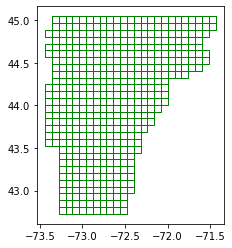

In [25]:
test_grid = create_awhere_grid(
    vt_bound_path, buffer_distance=0.08, cell_size=0.08)

test_grid.plot(facecolor="none", edgecolor="green")

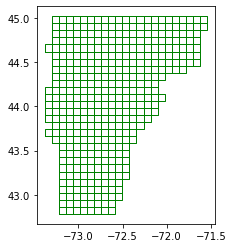

In [26]:
test_grid = create_awhere_grid(
    vt_bound_path, buffer_distance=0.025, cell_size=0.08)

test_grid.plot(facecolor="none", edgecolor="green")

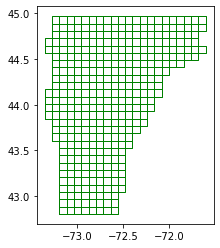

In [28]:
test_grid = create_awhere_grid(
    vt_bound_path, buffer_distance=0.0, cell_size=0.08)

test_grid.plot(facecolor="none", edgecolor="green")

In [29]:
test_grid

,geometry,centroid
43,"POLYGON ((-73.35790 43.84696, -73.27790 43.846...",POINT (-73.31790 43.88696)
44,"POLYGON ((-73.35790 43.92696, -73.27790 43.926...",POINT (-73.31790 43.96696)
45,"POLYGON ((-73.35790 44.00696, -73.27790 44.006...",POINT (-73.31790 44.04696)
46,"POLYGON ((-73.35790 44.08696, -73.27790 44.086...",POINT (-73.31790 44.12696)
52,"POLYGON ((-73.35790 44.56696, -73.27790 44.566...",POINT (-73.31790 44.60696)
...,...,...
635,"POLYGON ((-71.75790 44.80696, -71.67790 44.806...",POINT (-71.71790 44.84696)
636,"POLYGON ((-71.75790 44.88696, -71.67790 44.886...",POINT (-71.71790 44.92696)
661,"POLYGON ((-71.67790 44.56696, -71.59790 44.566...",POINT (-71.63790 44.60696)
664,"POLYGON ((-71.67790 44.80696, -71.59790 44.806...",POINT (-71.63790 44.84696)


In [32]:
def extract_centroids(grid):
    """Extracts the longitude and latitude centroids
    from a grid of polygons.
    
    Parameters
    ----------
    grid : geopandas GeoDataFrame
        Grid dataframe with polygon geometry.
    
    Returns
    -------
    centroid_list: list (of tuples)
        List containing (longitude, latitude) tuples.
    
    Example
    -------
    
    """
    # Create copy of dataframe (avoids altering the original)
    grid_extract = grid.copy()
    
    # Extract latitude and longitude to new columns
    grid_extract['longitude'] = grid_extract.centroid.apply(lambda point: point.x)
    grid_extract['latitude'] = grid_extract.centroid.apply(lambda point: point.y)
    
    # Extract centroid (as tuples) from grid
    centroid_list = [(row.longitude, row.latitude) for row in grid_extract.itertuples()]
    
    # Return centroids
    return centroid_list

In [34]:
test_list = extract_centroids(test_grid)

In [35]:
test_list

[(-73.36789189929631, 43.596981803142015),
 (-73.36789189929631, 43.67698180314201),
 (-73.36789189929631, 43.75698180314201),
 (-73.36789189929631, 43.83698180314201),
 (-73.36789189929631, 43.916981803142015),
 (-73.36789189929631, 43.996981803142006),
 (-73.36789189929631, 44.076981803142004),
 (-73.36789189929631, 44.156981803142),
 (-73.36789189929631, 44.63698180314199),
 (-73.36789189929631, 44.71698180314199),
 (-73.28789189929631, 42.79698180314203),
 (-73.28789189929631, 43.596981803142015),
 (-73.28789189929631, 43.67698180314201),
 (-73.28789189929631, 43.75698180314201),
 (-73.28789189929631, 43.83698180314201),
 (-73.28789189929631, 43.916981803142015),
 (-73.28789189929631, 43.996981803142006),
 (-73.28789189929631, 44.076981803142004),
 (-73.28789189929631, 44.156981803142),
 (-73.28789189929631, 44.236981803142),
 (-73.28789189929631, 44.316981803142),
 (-73.28789189929631, 44.39698180314199),
 (-73.28789189929631, 44.476981803141996),
 (-73.28789189929631, 44.55698180

In [36]:
len(test_list)

433